## ch02
- https://github.com/thampiman/interpretable-ai-book/blob/master/Chapter_02/chapter_02_lr_dt.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.9.25</div>
<div style="text-align: right"> Last update: 2023.9.25</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import math
from tqdm import tqdm

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from joblib import dump, load

plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

### Load data and EDA

In [3]:
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']

In [4]:
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [5]:
feature_rename = {'age': 'Age',
                  'sex': 'Sex',
                  'bmi': 'BMI',
                  'bp': 'BP',
                  's1': 'Total Cholesterol',
                  's2': 'LDL',
                  's3': 'HDL',
                  's4': 'Thyroid',
                  's5': 'Glaucoma',
                  's6': 'Glucose'}
df_data = pd.DataFrame(X, 
                       columns=diabetes['feature_names'])
df_data.rename(columns=feature_rename, inplace=True)
feature_names = list(df_data.columns.values)
df_data['target'] = y
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


In [6]:
df_data.head()

,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,Thyroid,Glaucoma,Glucose,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [7]:
corr = df_data.corr()
corr

,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,Thyroid,Glaucoma,Glucose,target
Age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
Sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
BMI,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
BP,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
Total Cholesterol,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
LDL,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
HDL,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
Thyroid,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
Glaucoma,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
Glucose,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


In [8]:
df_data.shape

(442, 11)

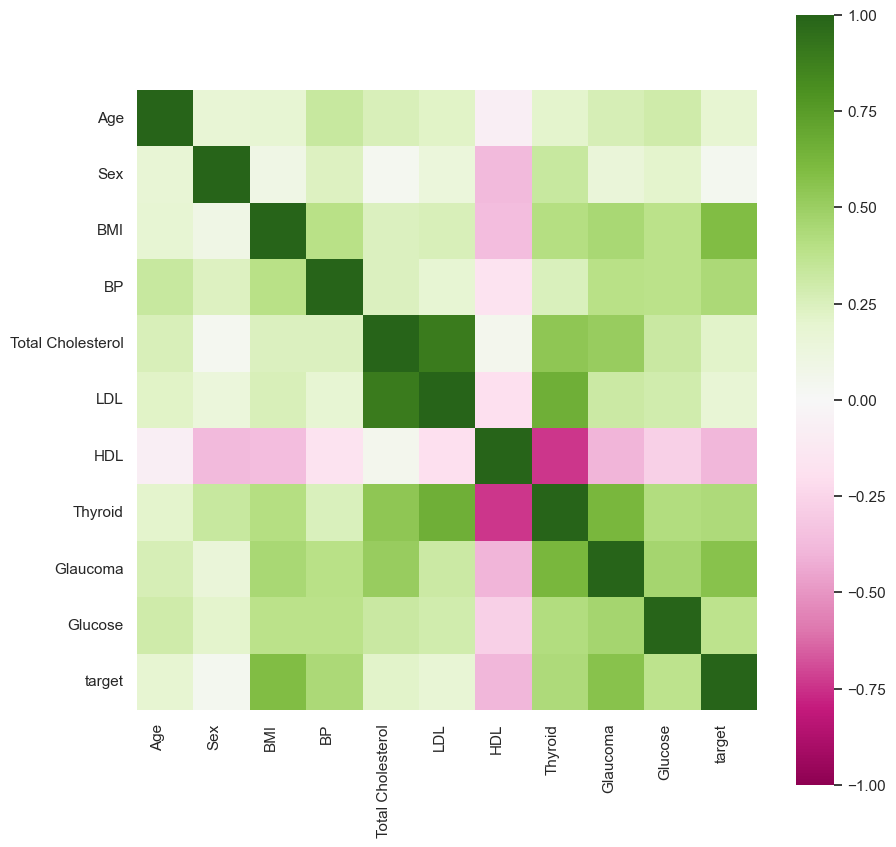

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap="PiYG",
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

- 마지막 row를 보면 타겟과 피처의 상관성을 보여준다.  
- BMI, BP, Total Cholesterol, HDL, Thyroid,Glaucoma, and Glucose가 중간 상관도를 가짐
- HDL은 음의 상관성을 가진다.

### Train, test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)

(353, 10)
(89, 10)


### Linear regression

![Alt text](image.png)

선형회귀 모델의 목표는 학습 데이터에서 타겟을 정확하게 예측하는 가중치를 찾는 것이다.  
이떄 gradient descent, Newton equation 등이 사용된다.

In [12]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [13]:
dump(lr_model, 'ch02_lr.joblib')

['ch02_lr.joblib']

### Baseline 모델

In [14]:
y_base = np.median(y_test)
mae = np.mean(np.abs(y_test - y_base))
print(mae)

62.21348314606742


In [15]:
rmse = math.sqrt(mean_squared_error(y_test, [y_base for _ in range(len(y_test))]))
print(rmse)

74.69646442605439


In [16]:
mape = np.mean(np.abs(y_test - y_base) / y_test) * 100
print(mape)

51.586778522876116


### Linreg 성능 평가

In [17]:
lr_model = load('ch02_lr.joblib')
y_pred = lr_model.predict(X_test)

In [18]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

42.794094679599944


In [19]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

53.85344583676594


In [20]:
mape = np.mean(np.abs(y_test - y_pred) / y_test) * 100
print(mape)

37.49982636756113


### Interpret Linear regression model

In [21]:
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


In [22]:
weights = lr_model.coef_

Text(0, 0.5, 'Features')

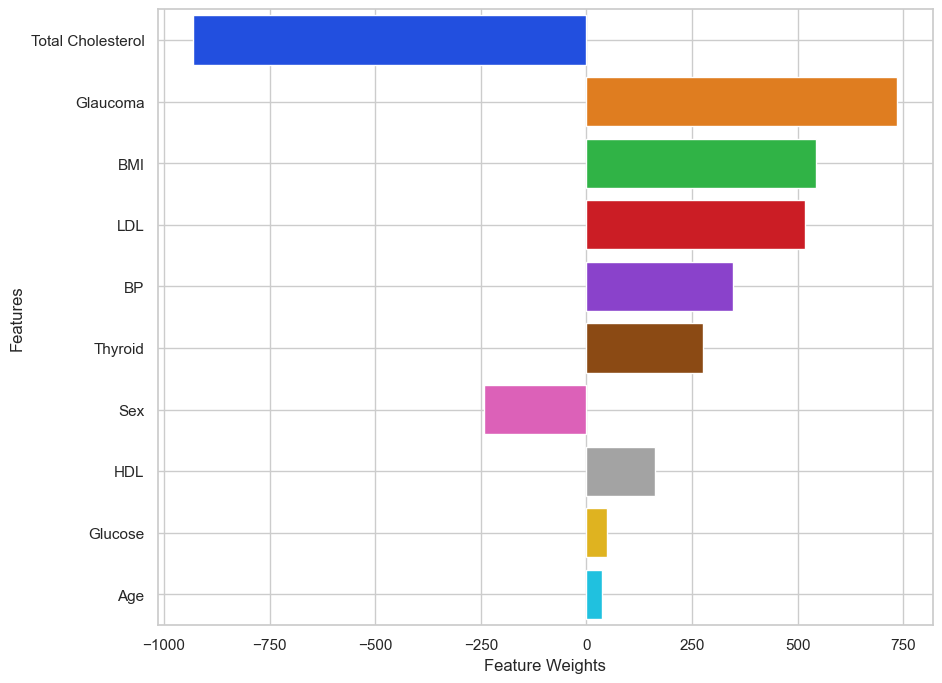

In [23]:
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')

- 위에서 총 콜레스테롤이 가장 중요, 전체 콜레스테롤이 음의 상관성을 보이는 이유는 콜레스테롤에 좋은 콜레스테롤도 상당수 포함되고 있기 때문
- 물론 나쁜 콜레스테롤인 LDL은 음의 상관성을 보임
- 그런데 좋은 콜레스테롤 HDL도 양의 상관성을 보이고, 중요도가 작다.  
- 이 부분은 상관성 행렬과 함깨 봐야 한다.
- 총 콜레스테롤과 LDL 사이에는 높은 상관관계과, 총 콜레스테롤과 HDL 사이에는 중간 정도 상관관계가 있다.
- 이로 인해 HDL 피처는 중복되는 것으로 간주된다???

- 또한 현재 glucose 값은 1년후 당뇨 진행을 예측하는데 매우 작은 기여를 한다.
- 상관관계를 보면 혈당 측정은 녹내장(glaucoma), 총 콜레스테롤과도 높은 상관성을 보임을 알 수 있다.
- 따라서 혈당 측정 값을 중복으로 취급한다. 이러한 현상을 다중공선성이라고 한다.
- ** 다중 공선성은 least square 기반의 선형 모델에서 해가된다.**  

최소 제곱을 사용하면 x2를 일정하게 유지하여 특징 x1에 대한 가중치, 즉 x1이 대상 변수 y에 미치는 영향을 추정합니다. 마찬가지로 x2에 대한 가중치는 x1을 일정하게 유지하여 추정합니다. x1과 x2가 선형인 경우, 이 둘은 함께 변화하며 대상 변수에 대한 영향을 정확하게 추정하기가 매우 어려워집니다. 모델에서 기능 중 하나가 완전히 중복됩니다. 앞서 당뇨병 모델에서 상관관계의 영향을 살펴봤는데, 목표 변수와 상관관계가 매우 높은 HDL 및 포도당과 같은 특징은 최종 모델에서 중요도가 매우 낮았습니다. 다중공선성 문제는 모델에서 중복되는 기능을 제거함으로써 극복할 수 있습니다. 연습 삼아 선형 회귀 모델의 성능을 개선할 수 있는지 확인하기 위해 이렇게 해보는 것을 적극 권장합니다.

다중 공선성은 해성하기 전에 처리해야한다.

### Traind decision tree model

In [24]:
dt_model = DecisionTreeRegressor(max_depth=None, random_state=42)
dt_model_depth3 = DecisionTreeRegressor(max_depth=3, random_state=42)

In [25]:
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [26]:
dt_model_depth3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [27]:
y_pred = dt_model.predict(X_test)

In [28]:
mae = np.mean(np.abs(y_test - y_pred))
print(mae)

54.52808988764045


In [29]:
y_pred_depth3 = dt_model_depth3.predict(X_test)

mae_depth3 = np.mean(np.abs(y_test - y_pred_depth3))
print(mae_depth3)

48.0965923002249


In [30]:
rmse_depth3 = math.sqrt(mean_squared_error(y_test, y_pred_depth3))
print(rmse_depth3)

59.60454104616319


In [31]:
mape_depth3 = np.mean(np.abs(y_test - y_pred_depth3) / y_test) * 100
print(mape_depth3)

43.0691295558855


### Interpret dt model

In [32]:
print(feature_names)

['Age', 'Sex', 'BMI', 'BP', 'Total Cholesterol', 'LDL', 'HDL', 'Thyroid', 'Glaucoma', 'Glucose']


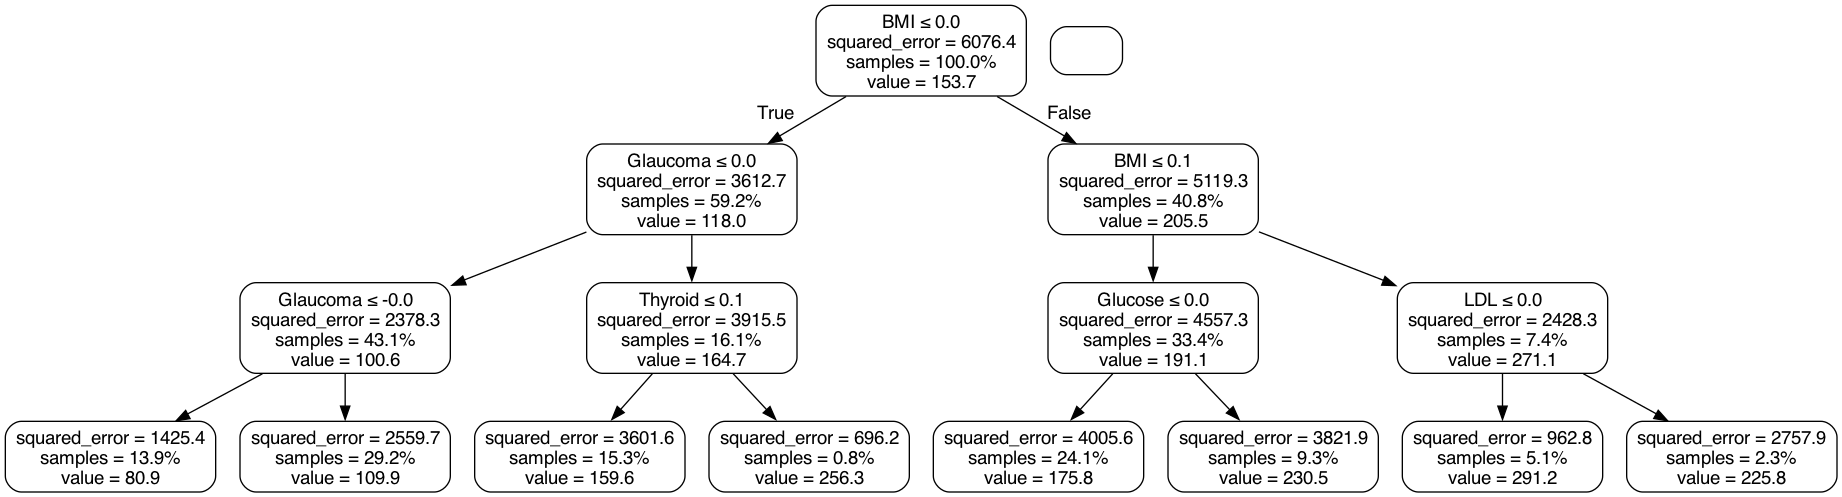

In [33]:
diabetes_dt_dot_data = StringIO()
export_graphviz(dt_model_depth3, 
                out_file=diabetes_dt_dot_data,
                filled=False, rounded=True,
                feature_names=feature_names,
                proportion=True,
                precision=1,
                special_characters=True)
dt_graph = pydotplus.graph_from_dot_data(diabetes_dt_dot_data.getvalue())  
Image(dt_graph.create_png())

Text(0, 0.5, 'Features')

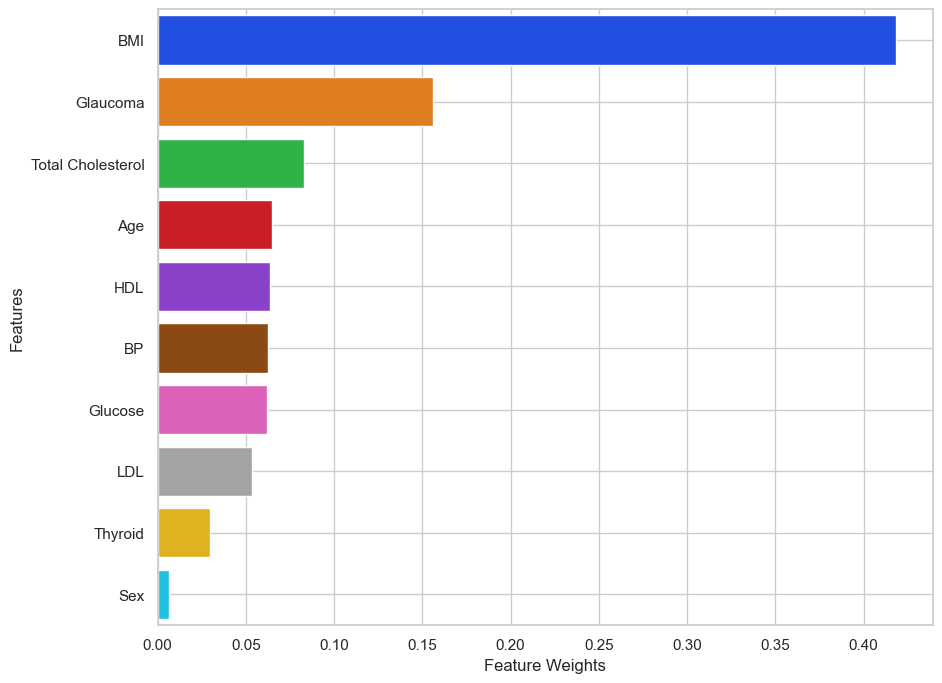

In [34]:
weights = dt_model.feature_importances_
feature_importance_idx = np.argsort(np.abs(weights))[::-1]
feature_importance = [feature_names[idx] for idx in feature_importance_idx]
feature_importance_values = [weights[idx] for idx in feature_importance_idx]
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_importance_values, y=feature_importance, ax=ax)
ax.grid(True)
ax.set_xlabel('Feature Weights')
ax.set_ylabel('Features')

결정트리는 입력과 타겟의 비선형 관계를 학습하기 때문에 
개별 입력에 대한 출력의 영향을 파악하기 어렵다.  

대신 글로벌 수준에서 타겟을 예측할 때, 각 피처의 상대적인 중요도를 계산 할 수 있다.

### Overfit, underfit

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.


findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font fami

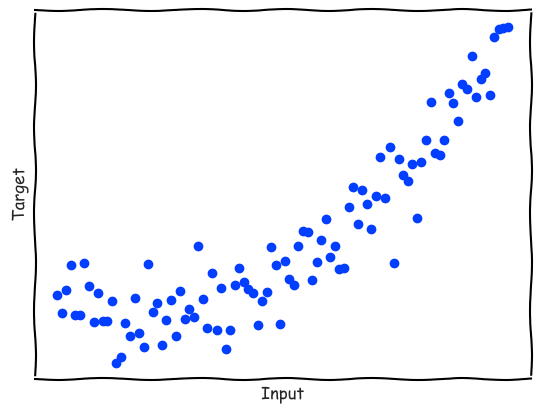

In [35]:
np.random.seed(42)
n_samples = 100

X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100

# Non-linear data
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

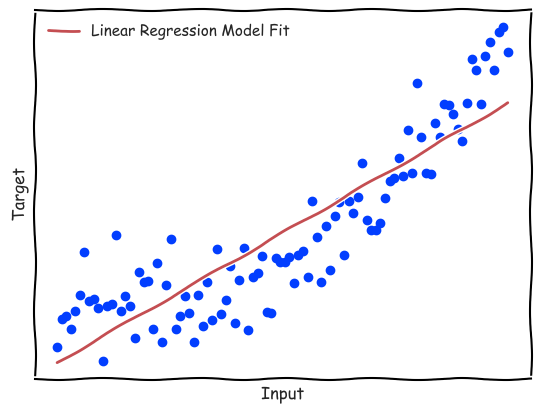

In [36]:
X = np.linspace(0, 10, 100)
rng = np.random.randn(n_samples) * 100

y = 2 * X**0.5 + X ** 3 + rng + 100
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
model_pred = lr.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Linear Regression Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.


findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Fo

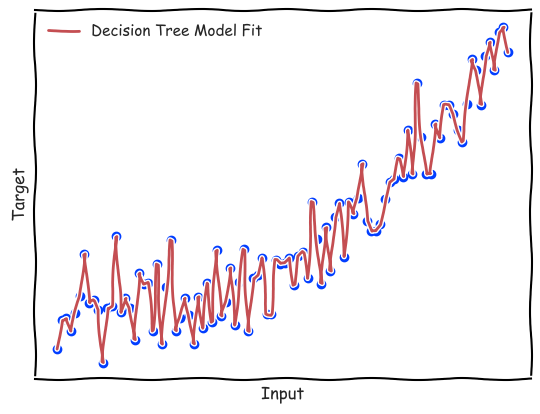

In [37]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X.reshape(-1, 1), y)
model_pred = dt.predict(X.reshape(-1,1))
# Underfitting
with plt.xkcd():
    f, ax = plt.subplots()
    ax.scatter(X, y)
    ax.plot(X, model_pred, 'r-', label='Decision Tree Model Fit');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.legend()

## 2.5 Generalized additive models (GAMs)

생략